<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
plt.style.use('seaborn')
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
# Downloading onto my local machine
import requests

url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv'
c = requests.get(url).content

with open('loan_train.csv', 'wb') as f:
    f.write(c)

### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


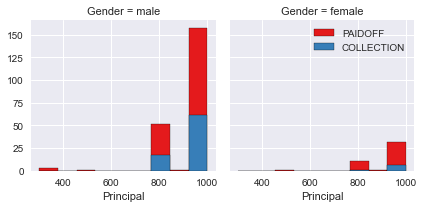

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

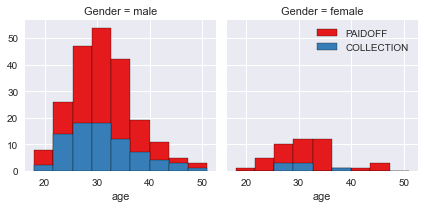

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


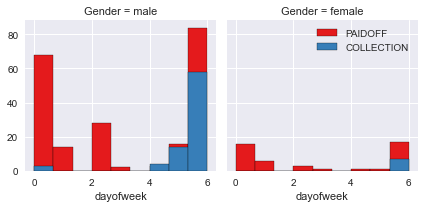

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical variables to binary variables and append them to the feature Data Frame


In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [18]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [22]:
# Note that I use Shuffle Split and GridSearchCV to get the best parameters (n_neighbors, max_depth, etc.)
# So I did not have to split using train_test_split()
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

shuffle_split = ShuffleSplit(n_splits=1, test_size=.2)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
param = [{'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}]
KNN = KNeighborsClassifier()
KNN_grid = GridSearchCV(KNN, param, cv=shuffle_split)
KNN_grid.fit(X,y)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}])

In [25]:
print(f"""The best n_neighbors: {KNN_grid.best_params_}
with score: {round(KNN_grid.best_score_, 4)}""")

# Setting KNN with the best n_neighbors
KNN = KNeighborsClassifier(KNN_grid.best_params_['n_neighbors'])
KNN.fit(X,y)

The best n_neighbors: {'n_neighbors': 7}
with score: 0.7429


KNeighborsClassifier(n_neighbors=7)

# Decision Tree


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [42]:
param = [{'max_depth': [2,3,4,5,6,7,8,9,10]}]
dtree = DecisionTreeClassifier(criterion='entropy')
tree_grid = GridSearchCV(dtree, param, cv=shuffle_split)
tree_grid.fit(X,y)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}])

In [48]:
print(f"""The best max_depth: {tree_grid.best_params_}
with score: {round(tree_grid.best_score_, 4)}""")

# Setting Tree with the best params
dtree = DecisionTreeClassifier(max_depth=tree_grid.best_params_['max_depth'], criterion='entropy')
dtree.fit(X,y)

The best max_depth: {'max_depth': 2}
with score: 0.7714


DecisionTreeClassifier(criterion='entropy', max_depth=2)

# Support Vector Machine


In [30]:
from sklearn.svm import SVC

In [31]:
clf = SVC()
param = [
    {'C': [1,0.1,0.01,0.001]},
    {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
]
svc_grid = GridSearchCV(clf, param, cv=shuffle_split)
svc_grid.fit(X,y)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 0.1, 0.01, 0.001]},
                         {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}])

In [32]:
print(f"""The best parameters: {svc_grid.best_params_}
with score: {round(svc_grid.best_score_, 4)}""")
# Setting SVC with the best n_neighbors params

clf = SVC(C=svc_grid.best_params_['C'])
clf.fit(X,y)

The best parameters: {'C': 0.1}
with score: 0.7857


SVC(C=0.1)

# Logistic Regression


In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
log_reg = LogisticRegression()
param = [
    {'C':[1.0,0.1,0.01,0.001]},
    {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
]
log_grid = GridSearchCV(log_reg, param, cv=shuffle_split)
log_grid.fit(X,y)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid=[{'C': [1.0, 0.1, 0.01, 0.001]},
                         {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}])

In [35]:
log_grid.best_params_

{'solver': 'liblinear'}

In [38]:
print(f"""The best parameters: {log_grid.best_params_}
with score: {round(log_grid.best_score_, 4)}""")

# Setting the best params
log_reg = LogisticRegression(solver=log_grid.best_params_['solver'])
log_reg.fit(X,y)

The best parameters: {'solver': 'liblinear'}
with score: 0.7


LogisticRegression(solver='liblinear')

# Model Evaluation using Test set


In [49]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [50]:
url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'
c = requests.get(url).content

with open('loan_test.csv', 'wb') as f:
    f.write(c)

### Load Test set for evaluation


In [51]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Preparing the test features and target

In [52]:
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [53]:
X_test = Feature
X_test = preprocessing.StandardScaler().fit_transform(X_test)
y_test = test_df['loan_status'].values

In [54]:
# KNN
y_knn = KNN.predict(X_test)
print(f"""Jaccard score KNN: {jaccard_score(y_test, y_knn, pos_label='PAIDOFF')}
F1 score KNN: {f1_score(y_test, y_knn, pos_label='PAIDOFF')}
""")

Jaccard score KNN: 0.72
F1 score KNN: 0.8372093023255814



In [55]:
# Decision Tree
y_dtree = dtree.predict(X_test)
print(f"""Jaccard score DTree: {jaccard_score(y_test, y_dtree, pos_label='PAIDOFF')}
F1 score DTree: {f1_score(y_test, y_dtree, pos_label='PAIDOFF')}
""")

Jaccard score DTree: 0.7407407407407407
F1 score DTree: 0.851063829787234



In [56]:
# SVM
y_svm = clf.predict(X_test)
print(f"""Jaccard score SVM: {jaccard_score(y_test, y_svm, pos_label='PAIDOFF')}
F1 score SVM: {f1_score(y_test, y_svm, pos_label='PAIDOFF')}
""")

Jaccard score SVM: 0.7407407407407407
F1 score SVM: 0.851063829787234



In [58]:
# Logistic Regression
y_log = log_reg.predict(X_test)
y_log_proba = log_reg.predict_proba(X_test)

print(f"""Jaccard score Log: {jaccard_score(y_test, y_log, pos_label='PAIDOFF')}
F1 score Log: {f1_score(y_test, y_log, pos_label='PAIDOFF')}
Log loss: {log_loss(y_test, y_log_proba)}
""")

Jaccard score Log: 0.7547169811320755
F1 score Log: 0.8602150537634409
Log loss: 0.4791925061797866



# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.72       | 0.8372        | NA      |
| Decision Tree      | 0.7407       | 0.851        | NA      |
| SVM                | 0.7407       | 0.851        | NA      |
| LogisticRegression | 0.7547       | 0.8602        | 0.4791       |


The best model is **Logistic Regression**

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
